# Set up

In [1]:
%%capture
!pip install bertopic datasets accelerate bitsandbytes xformers adjustText

In [2]:
%%capture
!pip3 install torch==2.2.0

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

import torch
from torch import cuda
from torch import bfloat16
import transformers
import bisect
from tqdm import tqdm

In [4]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset

In [6]:
loading_dir='./drive/MyDrive/Topic Mining Project/new_data/'

In [7]:
# 1. load data
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.raw_data = pd.read_csv(loading_dir+"news_data/news_with_ticker.csv", index_col=0)
        self.raw_data['description'].fillna('', inplace=True)
        self.raw_data.dropna(subset=['title','publishedDate'], inplace=True)

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, i):
        text = self.raw_data['title'].iloc[i] + ' | ' + self.raw_data['description'].iloc[i]
        label = self.raw_data['tags'].iloc[i]
        timestamp = self.raw_data['publishedDate'].iloc[i]


        return text, label, timestamp


print("loading data...")
dataset = Dataset()
len(dataset)

loading data...


349897

In [8]:
documents=dataset[:][0]
timestamp=dataset[:][2]

In [26]:
timestamp.value_counts().sort_index()

publishedDate
2024-01-12    4054
2024-01-13    3743
2024-01-14    3664
2024-01-15    4191
2024-01-16    4373
              ... 
2024-04-09    3559
2024-04-10    3530
2024-04-11    3592
2024-04-13     169
2024-04-14      13
Name: count, Length: 93, dtype: int64

# Model Evaluation
- mainly test the difference of clustering method

In [12]:
class Evaluation:
  """
  dataset: pd.series
  embeddings: arrays
  cluster_method = ('KMeans','hdbscan')
  K_cluster: int
  hdb_min_size:int
  """
  def __init__(self,dataset,embeddings,cluster_method,K_cluster=None,hdb_min_size=None):
      self.data=dataset
      self.embeddings=embeddings
      self.cluster_method=cluster_method
      self.K_cluster = K_cluster
      self.hdb_min_size = hdb_min_size

      self.topic_model = self.Bertopic_model()
      self.npmi=self.cal_coherence_score()
      self.diversity=self.cal_diversity_score()


  def Bertopic_model(self):
        umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
        hdbscan_model = HDBSCAN(min_cluster_size=self.hdb_min_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
        cluster_model = KMeans(n_clusters=self.K_cluster, random_state=42) if self.cluster_method == "KMeans" else hdbscan_model
        vectorizer_model = CountVectorizer(stop_words="english")

        topic_model = BERTopic(
            # Sub-models
            embedding_model=embedding_model,
            vectorizer_model=vectorizer_model,
            umap_model=umap_model,
            hdbscan_model=cluster_model,

            # Hyperparameters
            top_n_words=10,  # the number of words per topic that you want to be extracted
            verbose=True)

        # Train model
        topics, probs = topic_model.fit_transform(self.data,self.embeddings)
        return topic_model


  def cal_coherence_score(self):
      topic_model = self.topic_model
      Doc=self.data

      # Preprocess Documents
      documents = pd.DataFrame({"Document": Doc,"ID": range(len(Doc)),"Topic": topic_model.topics_})
      documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
      cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

      # Extract vectorizer and analyzer from BERTopic
      vectorizer = topic_model.vectorizer_model
      analyzer = vectorizer.build_analyzer()

      # Use .get_feature_names_out() if you get an error with .get_feature_names()
      words = vectorizer.get_feature_names_out()

      # Extract features for Topic Coherence evaluation
      tokens = [analyzer(doc) for doc in cleaned_docs]
      dictionary = corpora.Dictionary(tokens)
      corpus = [dictionary.doc2bow(token) for token in tokens]

      # Extract words in each topic if they are non-empty and exist in the dictionary
      topic_words = []
      for topic in range(len(set(topic_model.topics_))-topic_model._outliers):
          words = list(zip(*topic_model.get_topic(topic)))[0]
          words = [word for word in words if word in dictionary.token2id]
          topic_words.append(words)
      topic_words = [words for words in topic_words if len(words) > 0]

      # Evaluate Coherence
      coherence_model = CoherenceModel(topics=topic_words,
                                      texts=tokens,
                                      corpus=corpus,
                                      dictionary=dictionary,
                                      coherence='c_npmi') ##可改为'c_npmi','c_v'
      coherence = coherence_model.get_coherence()

      return coherence

  def cal_diversity_score(self):
      model = self.topic_model
      all_topics=model.get_topics() ##每个topic下主题词的概率，不包括-1
      all_topic_num=len(all_topics)*len(all_topics[0])
      unique_words=set()
      for key in all_topics:
          topic = [i[0] for i in all_topics[key]]
          unique_words = unique_words.union(set(topic))
      diversity_score=len(unique_words)/all_topic_num
      return diversity_score

# Result

In [28]:
def sample(date_time):
    indices = timestamp[timestamp == date_time].index
    sampled_docs = documents.iloc[indices]
    return sampled_docs

In [29]:
def test(sampled_docs, kmeans_params, hdbscan_params):
    ##  Pre-calculate embeddings（根据时间计算当天的embeddings）
    embedding_model = SentenceTransformer("BAAI/bge-small-en")
    embeddings = embedding_model.encode(sampled_docs.tolist(),show_progress_bar=True)

    evaluation_data = {'method':[],'size':[],'npmi': [], 'diversity_score': []}

    for value in kmeans_params:
        evaluation = Evaluation(sampled_docs, embeddings, cluster_method='KMeans', K_cluster=value)
        evaluation_data['method'].append('Kmeans')
        evaluation_data['size'].append(value)
        evaluation_data['npmi'].append(evaluation.npmi)
        evaluation_data['diversity_score'].append(evaluation.diversity)

    for value in hdbscan_params:
        evaluation_data['method'].append('hdbscan')
        evaluation_data['size'].append(value)
        evaluation = Evaluation(sampled_docs, embeddings, cluster_method='hdbscan', hdb_min_size=value)
        evaluation_data['npmi'].append(evaluation.npmi)
        evaluation_data['diversity_score'].append(evaluation.diversity)

    # Set index labels
    index_labels = [f"KMeans_{value}" for value in kmeans_params] + [f"hdbscan_{value}" for value in hdbscan_params]

    return evaluation_data

In [30]:
def result(kmeans_params,hdbscan_params,num):
  final_data={}

  for published_date in timestamp.unique()[:num]:
    sample_data=sample(published_date)
    evaluation_data=test(sample_data, kmeans_params, hdbscan_params)
    final_data[published_date]=evaluation_data
  return final_data

In [ ]:
kmeans_params = [100, 80, 50, 30, 10]
hdbscan_params = [10, 20, 30, 40, 50]
res =result(kmeans_params,hdbscan_params,10)

In [40]:
df = pd.DataFrame()

for date, values in res.items():
    temp_df = pd.DataFrame(values)
    temp_df['date'] = date
    df = pd.concat([df, temp_df], ignore_index=True)

In [ ]:
df.to_csv('./drive/MyDrive/Topic Mining Project/evaluation/evaluation_10.csv')

In [58]:
df=pd.read_csv('./drive/MyDrive/Topic Mining Project/evaluation/evaluation_10.csv',index_col=0)

In [59]:
df['method_cluster'] = df.apply(lambda row: f"{row['method']}_{row['size']}", axis=1)

In [60]:
df

,method,size,npmi,diversity_score,date,method_cluster
0,Kmeans,100,0.156758,0.799000,2024-01-12,Kmeans_100
1,Kmeans,80,0.156634,0.822500,2024-01-12,Kmeans_80
2,Kmeans,50,0.166037,0.810000,2024-01-12,Kmeans_50
3,Kmeans,30,0.163616,0.833333,2024-01-12,Kmeans_30
4,Kmeans,10,0.175634,0.900000,2024-01-12,Kmeans_10
...,...,...,...,...,...,...
95,hdbscan,10,0.191474,0.697297,2024-01-21,hdbscan_10
96,hdbscan,20,0.166655,0.780000,2024-01-21,hdbscan_20
97,hdbscan,30,0.181717,0.757895,2024-01-21,hdbscan_30
98,hdbscan,40,0.349774,0.780000,2024-01-21,hdbscan_40


In [72]:
def plot(df, dates):
    num_dates = len(dates)
    plt.figure(figsize=(10*num_dates, 8))

    for i, date in enumerate(dates, start=1):
        plt.subplot(1, num_dates, i)

        subset_df = df[df['date'] == date]

        plt.plot(subset_df['method_cluster'], subset_df['npmi'], marker='o', label='NPMI')
        plt.plot(subset_df['method_cluster'], subset_df['diversity_score'], marker='o', label='Diversity Score')

        plt.title(f'Evaluation Metrics vs. Cluster Size ({date})')
        plt.xlabel('Method and Cluster Size')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

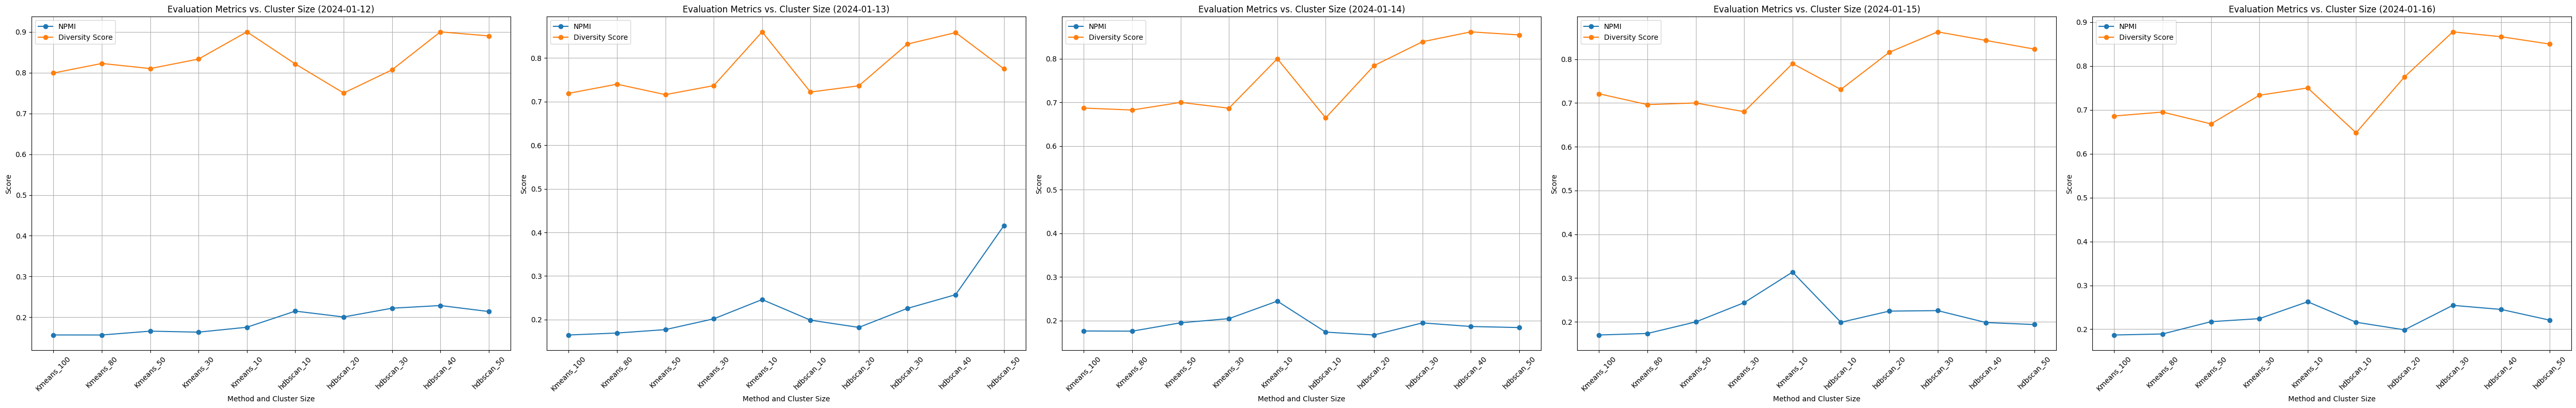

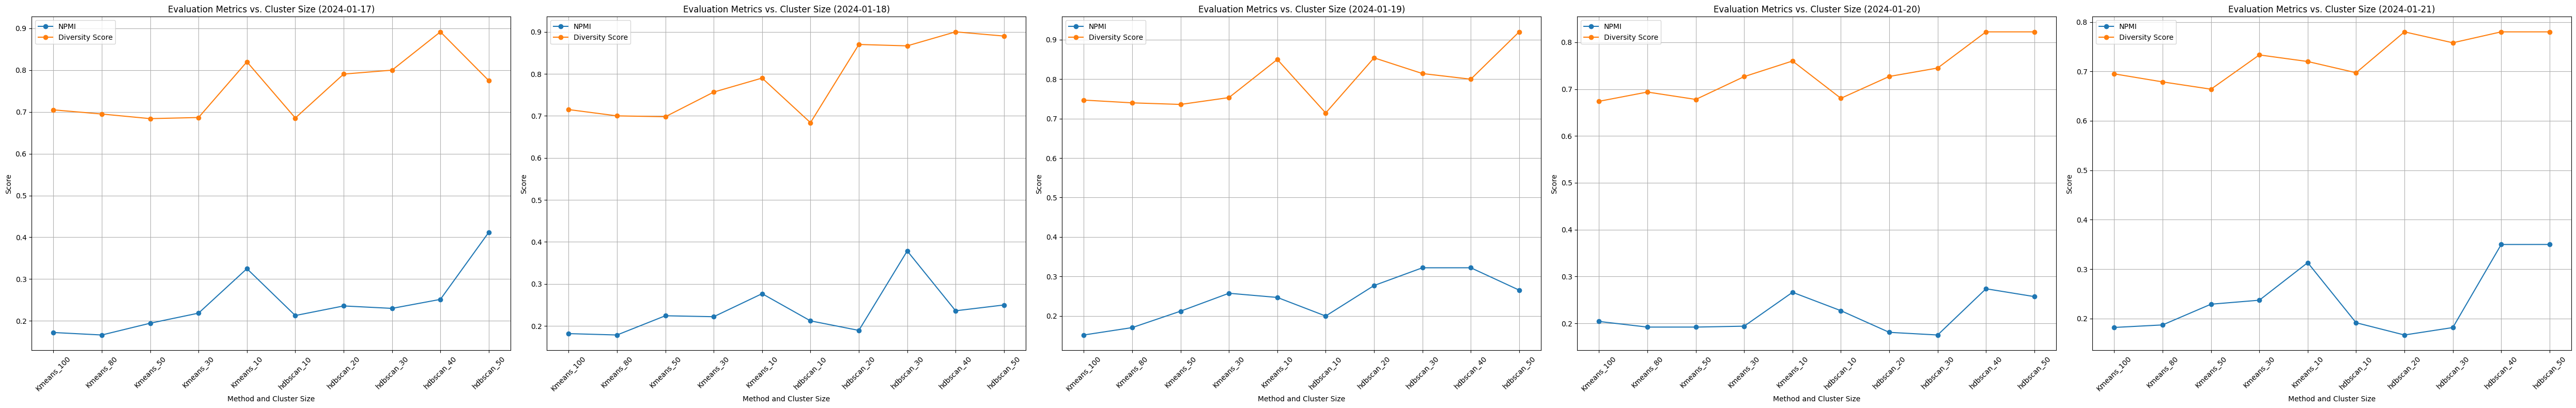

In [76]:
plot(df, ['2024-01-12', '2024-01-13', '2024-01-14','2024-01-15','2024-01-16',])
plot(df, ['2024-01-17','2024-01-18', '2024-01-19','2024-01-20','2024-01-21'])

# Appendix

* [coherence measures指标介绍](https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c)
* [coherence代码参考-Bertopic官方给出](https://github.com/MaartenGr/BERTopic/issues/90)
* [知乎-主题模型评价指标](https://zhuanlan.zhihu.com/p/587467839)
* [diversity参考-OCTIS-Bertopi官方推荐](https://github.com/MIND-Lab/OCTIS/blob/7529e23c0f852076a46b88c8c073d54a8bf0d26b/octis/evaluation_metrics/diversity_metrics.py)


**diversity score**

*Diversity Score for Each Topic* = $\frac{\text{Number of unique words in the topic}}{\text{Total number of words in the topic}}$

*Overall Diversity Score* = $\frac{\sum \text{Diversity Score for each topic}}{\text{Total number of topics}}$



> For example:  
Topic 1: Diversity score = 3 unique words / 4 total words = 0.75  
Topic 2: Diversity score = 2 unique words / 4 total words = 0.5  
Topic 3: Diversity score = 2 unique words / 4 total words = 0.5  
Overall Diversity Score: (0.75 + 0.5 + 0.5) / 3 = 0.5833




**Coherence Score**   


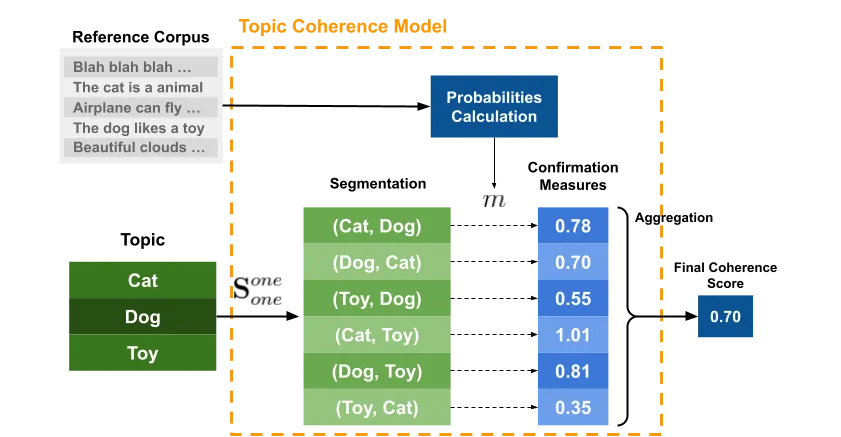

**example of coherence score pipline:**       
* segmentation(one-one):assume one of the segmentation is (Cat,Dog) -> (w1,w2)    
* P-calculation: then, we can calculate $P(w1,w2)$,$P(w1)$,$P(w2)$     
* C-measure: then, we can calculate $P(w1|w2)=P(w1,w2)/P(w2)$ to get confirmation score      
* aggregation: finnaly, we can get final coherence score

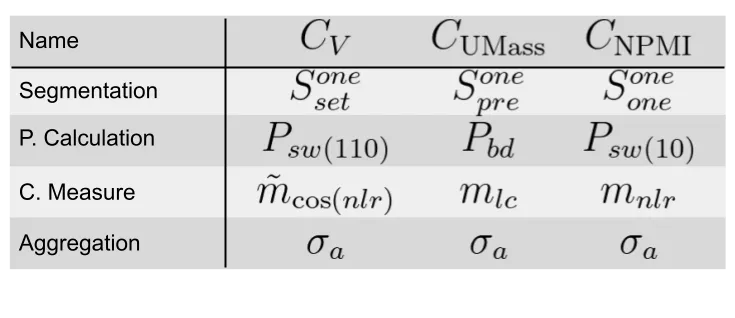

In [ ]:
## calculate coherence score
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
def cal_coherence_score(Doc,topic_model,method):
    # Preprocess Documents
    documents = pd.DataFrame({"Document": Doc,"ID": range(len(Doc)),"Topic": topic_model.topics_})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Use .get_feature_names_out() if you get an error with .get_feature_names()
    words = vectorizer.get_feature_names_out()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract words in each topic if they are non-empty and exist in the dictionary
    topic_words = []
    for topic in range(len(set(topic_model.topics_))-topic_model._outliers):
        words = list(zip(*topic_model.get_topic(topic)))[0]
        words = [word for word in words if word in dictionary.token2id]
        topic_words.append(words)
    topic_words = [words for words in topic_words if len(words) > 0]

    # Evaluate Coherence
    coherence_model = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence=method) ##可改为'c_npmi','c_v'
    coherence = coherence_model.get_coherence()
    return coherence

In [ ]:
## calculate diversity score
def cal_diversity_score(model):
    all_topics=model.get_topics() ##每个topic下主题词的概率，不包括-1
    all_topic_num=len(all_topics)*len(all_topics[0])
    unique_words=set()
    for key in all_topics:
        topic = [i[0] for i in all_topics[key]]
        unique_words = unique_words.union(set(topic))
    td=len(unique_words)/all_topic_num
    return td